In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Data/Deepglobe.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/723199_sat.jpg  
  inflating: /content/dataset/train/723226_mask.png  
  inflating: /content/dataset/train/723226_sat.jpg  
  inflating: /content/dataset/train/723436_mask.png  
  inflating: /content/dataset/train/723436_sat.jpg  
  inflating: /content/dataset/train/723483_mask.png  
  inflating: /content/dataset/train/723483_sat.jpg  
  inflating: /content/dataset/train/723622_mask.png  
  inflating: /content/dataset/train/723622_sat.jpg  
  inflating: /content/dataset/train/723722_mask.png  
  inflating: /content/dataset/train/723722_sat.jpg  
  inflating: /content/dataset/train/723970_mask.png  
  inflating: /content/dataset/train/723970_sat.jpg  
  inflating: /content/dataset/train/723990_mask.png  
  inflating: /content/dataset/train/723990_sat.jpg  
  inflating: /content/dataset/train/724095_mask.png  
  inflating: /content/dataset/train/724095_sat.jpg  
  inflating: /content/dataset/train/7244

In [3]:
!pip install tensorflow keras opencv-python timm albumentations matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.5 MB/s eta 0:00:00


In [5]:
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Data Generator برای لود کردن تصاویر و ماسک‌ها به صورت batch
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames=None, image_dir='', mask_dir='', batch_size=8, image_size=(256, 256), shuffle=True):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        # تولید یک batch از داده‌ها
        batch_image_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]


        images = []
        masks = []

        for file_name in batch_image_filenames:
            img_path = os.path.join(self.image_dir, file_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.image_size)
            images.append(image)

            if self.mask_filenames is not None:
                mask_name = file_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = cv2.imread(mask_path, 0)
                mask = cv2.resize(mask, self.image_size)

                # تبدیل ماسک به باینری (مقادیر 0 و 1)
                mask = (mask > 128).astype(np.uint8)  # هر پیکسل بزرگتر از 128 را 1 و بقیه را 0 می‌کند.

                mask = np.expand_dims(mask, axis=-1)
                masks.append(mask)

        images = np.array(images)
        if self.mask_filenames is not None:
            masks = np.array(masks)
            return images, masks
        else:
            return images

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_filenames))
            np.random.shuffle(indices)
            self.image_filenames = [self.image_filenames[i] for i in indices]
            if self.mask_filenames is not None:
                self.mask_filenames = [self.mask_filenames[i] for i in indices]

# تقسیم داده‌ها به train و validation
train_image_dir = '/content/dataset/train'
train_mask_dir = '/content/dataset/train'

# لیست فایل‌های تصویر و ماسک‌ها را لود می‌کنیم
image_filenames = sorted([f for f in os.listdir(train_image_dir) if f.endswith('_sat.jpg')])
mask_filenames = sorted([f for f in os.listdir(train_mask_dir) if f.endswith('_mask.png')])

# تقسیم داده‌ها به 80% train و 20% validation
train_image_filenames, valid_image_filenames, train_mask_filenames, valid_mask_filenames = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42)

# ساخت DataGenerator برای train
train_generator = DataGenerator(image_filenames=train_image_filenames, mask_filenames=train_mask_filenames,
                                image_dir=train_image_dir, mask_dir=train_mask_dir, batch_size=8, image_size=(256, 256))

# ساخت DataGenerator برای validation
valid_generator = DataGenerator(image_filenames=valid_image_filenames, mask_filenames=valid_mask_filenames,
                                image_dir=train_image_dir, mask_dir=train_mask_dir, batch_size=8, image_size=(256, 256), shuffle=False)

# تست روی فایل‌های test
test_image_dir = '/content/dataset/test'
test_image_filenames = sorted([f for f in os.listdir(test_image_dir) if f.endswith('_sat.jpg')])

# ساخت DataGenerator برای test (بدون ماسک)
test_generator = DataGenerator(image_filenames=test_image_filenames, image_dir=test_image_dir, batch_size=8, image_size=(256, 256), shuffle=False)


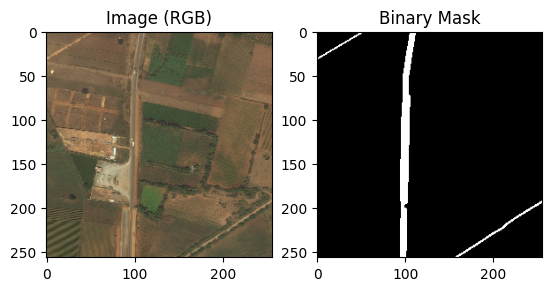

In [6]:
import matplotlib.pyplot as plt
import cv2

# دریافت یک batch از تصاویر و ماسک‌ها
images, masks = train_generator[0]

# تبدیل تصاویر از BGR به RGB
images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# نمایش یک تصویر و ماسک مربوطه
plt.subplot(1, 2, 1)
plt.imshow(images_rgb[0])
plt.title('Image (RGB)')

plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title('Binary Mask')

plt.show()





In [7]:
print(f"Training samples: {len(train_generator)}, Validation samples: {len(valid_generator)}")


Training samples: 622, Validation samples: 155


In [6]:
# from tensorflow.keras.utils import Sequence
# import cv2
# import numpy as np
# import os

# # Data Generator برای لود کردن تصاویر و ماسک‌ها به صورت batch
# class DataGenerator(Sequence):
#     def __init__(self, image_dir, mask_dir=None, batch_size=8, image_size=(256, 256), shuffle=True):
#         super().__init__()
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.shuffle = shuffle
#         self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('_sat.jpg')])
#         if mask_dir:
#             self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.png')])
#         self.on_epoch_end()

#     def __len__(self):
#         # تعداد batch‌ها در هر epoch
#         return int(np.floor(len(self.image_filenames) / self.batch_size))

#     def __getitem__(self, index):
#         # تولید یک batch از داده‌ها
#         batch_image_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]

#         images = []
#         masks = []

#         for file_name in batch_image_filenames:
#             img_path = os.path.join(self.image_dir, file_name)
#             image = cv2.imread(img_path)
#             image = cv2.resize(image, self.image_size)
#             images.append(image)

#             if self.mask_dir:
#                 mask_name = file_name.replace('_sat.jpg', '_mask.png')
#                 mask_path = os.path.join(self.mask_dir, mask_name)
#                 mask = cv2.imread(mask_path, 0)
#                 mask = cv2.resize(mask, self.image_size)
#                 mask = np.expand_dims(mask, axis=-1)
#                 mask = mask /255.0
#                 masks.append(mask)

#         images = np.array(images)
#         if self.mask_dir:
#             masks = np.array(masks)
#             return images, masks
#         else:
#             return images

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.image_filenames)

# # استفاده از DataGenerator برای لود کردن داده‌ها
# train_image_dir = '/content/drive/MyDrive/train'
# train_mask_dir = '/content/drive/MyDrive/train'

# valid_image_dir = '/content/drive/MyDrive/valid'
# test_image_dir = '/content/drive/MyDrive/test'

# # ساخت DataGenerator برای train
# train_generator = DataGenerator(image_dir=train_image_dir, mask_dir=train_mask_dir, batch_size=4, image_size=(256, 256))

# # ساخت DataGenerator برای validation و test فقط با تصاویر
# valid_generator = DataGenerator(image_dir=valid_image_dir, batch_size=4, image_size=(256, 256), shuffle=False)
# test_generator = DataGenerator(image_dir=test_image_dir, batch_size=4, image_size=(256, 256), shuffle=False)


In [7]:
# # دریافت یک batch از داده‌های train
# images, masks = next(iter(train_generator))

# # پیش‌بینی با مدل
# predictions = model.predict(images)

# # چاپ شکل (dimensions) خروجی‌ها
# print(f"Shape of images: {images.shape}")
# print(f"Shape of masks: {masks.shape}")
# print(f"Shape of predictions: {predictions.shape}")

In [8]:
print(f"Training samples: {len(train_generator)}, Validation samples: {len(valid_generator)}")

Training samples: 622, Validation samples: 155


In [8]:
import tensorflow as tf

# یک لایه سفارشی برای انجام Patch Embedding
class PatchEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, patch_size=4, embed_dim=48, **kwargs):
        super(PatchEmbeddingLayer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, images):
        # تبدیل تصویر به پچ‌های کوچک
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = tf.reshape(patches, [tf.shape(patches)[0], -1, self.patch_size * self.patch_size * 3])
        return self.dense(patches)

# یک بلوک از Swin Transformer شامل Self Attention و MLP
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, mlp_ratio=4., **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=dim // 2)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(int(dim * mlp_ratio)),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Dense(dim)
        ])

    def call(self, x):
        # محاسبه Self Attention
        h = x
        x = self.norm1(x)
        x = self.attn(x, x)
        x = x + h

        # محاسبه MLP
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + h
        return x

# Swin Transformer نهایی
def swin_transformer(input_shape=(256, 256, 3), patch_size=4, num_heads=2, window_size=7, embed_dim=48):
    inputs = tf.keras.Input(shape=input_shape)

    # مرحله اول: تبدیل تصویر به پچ‌ها با استفاده از لایه سفارشی
    x = PatchEmbeddingLayer(patch_size=patch_size, embed_dim=embed_dim)(inputs)

    # مرحله دوم: بلوک‌های Swin Transformer
    x = SwinTransformerBlock(dim=embed_dim, num_heads=num_heads, window_size=window_size)(x)

    # Global Pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    return tf.keras.Model(inputs, x)

# ساخت مدل Swin Transformer
swin_model = swin_transformer()

# نمایش خلاصه مدل
swin_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_layer                │ (None, None, 48)            │           2,352 │
│ (PatchEmbeddingLayer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_block               │ (None, None, 48)            │          28,272 │
│ (SwinTransformerBlock)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,624 (119.62 KB)

 Trainable params: 30,624 (119.62 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# from tensorflow.keras.layers import Conv2D, UpSampling2D

# # ساخت مدل نهایی با Swin Transformer و CNN
# def build_conswin_model(input_shape=(512, 512, 3)):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Swin Transformer به عنوان backbone
#     swin_backbone = swin_transformer(input_shape=input_shape)  # استفاده از تابع swin_transformer
#     swin_output = swin_backbone(inputs)

#     # تبدیل خروجی Swin Transformer به ابعاد مناسب برای لایه‌های کانولوشنی
#     x = tf.keras.layers.Reshape((16, 16, -1))(swin_output)  # تنظیم دستی ابعاد (در اینجا فرض شده که ابعاد خروجی 16x16 است)

#     # لایه‌های CNN
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی تصویر
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی تصویر
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی تصویر

#     # لایه نهایی برای تولید نقشه‌های تقسیم‌بندی (segmentation map)
#     final_output = Conv2D(1, (1, 1), activation='sigmoid')(x)

#     # ساخت مدل نهایی
#     model = tf.keras.Model(inputs=inputs, outputs=final_output)

#     # کامپایل مدل
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model

# # ساخت مدل
# model = build_conswin_model()

# # نمایش خلاصه مدل
# model.summary()

In [11]:
# from tensorflow.keras.layers import Conv2D, UpSampling2D

# # ساخت مدل نهایی با Swin Transformer و CNN
# def build_conswin_model(input_shape=(256, 256, 3)):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Swin Transformer به عنوان backbone
#     swin_backbone = swin_transformer(input_shape=input_shape)  # استفاده از تابع swin_transformer
#     swin_output = swin_backbone(inputs)

#     # چاپ ابعاد خروجی Swin Transformer
#     print(f"Output shape of Swin Transformer: {swin_output.shape}")

#     # ادامه پردازش CNN بعد از بررسی ابعاد
#     # برای Reshape ابتدا ابعاد صحیح خروجی Swin Transformer را چاپ می‌کنیم و سپس اصلاح می‌کنیم

#     return tf.keras.Model(inputs=inputs, outputs=swin_output)

# # ساخت مدل
# model = build_conswin_model()

# # نمایش خلاصه مدل
# model.summary()

In [9]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dense, Reshape

# # ساخت مدل نهایی با Swin Transformer و CNN
# def build_conswin_model(input_shape=(256, 256, 3)):  # تغییر ابعاد ورودی به 256x256
#     inputs = tf.keras.Input(shape=input_shape)

#     # Swin Transformer به عنوان backbone
#     swin_backbone = swin_transformer(input_shape=input_shape)  # استفاده از تابع swin_transformer
#     swin_output = swin_backbone(inputs)

#     # تبدیل خروجی Swin Transformer به ابعاد مناسب
#     x = Dense(8 * 8 * 64, activation='relu')(swin_output)  # تنظیم ابعاد به 8x8x64
#     x = Reshape((8, 8, 64))(x)  # تبدیل به نقشه ویژگی 2D با ابعاد 8x8

#     # لایه‌های CNN برای بزرگ‌نمایی تصویر
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی به 16x16
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی به 32x32
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D(size=(2, 2))(x)  # بزرگ‌نمایی به 64x64
#     x = UpSampling2D(size=(4, 4))(x)  # بزرگ‌نمایی به 256x256

#     # لایه نهایی برای تولید نقشه‌های تقسیم‌بندی (segmentation map)
#     final_output = Conv2D(1, (1, 1), activation='sigmoid')(x)

#     # ساخت مدل نهایی
#     model = tf.keras.Model(inputs=inputs, outputs=final_output)

#     # کامپایل مدل
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model
# import tensorflow.keras.backend as K

# # تعریف متریک IoU (Intersection over Union)
# def iou(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred))
#     union = K.sum(y_true) + K.sum(y_pred) - intersection
#     return intersection / (union + K.epsilon())

# # تعریف متریک F1-Score
# def f1_score(y_true, y_pred):
#     def precision(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     precision_val = precision(y_true, y_pred)
#     recall_val = recall(y_true, y_pred)
#     return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


import tensorflow.keras.backend as K

# تعریف متریک IoU (Intersection over Union)
def iou(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # تبدیل y_true به float32
    y_pred = K.cast(y_pred, 'float32')  # تبدیل y_pred به float32

    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou_val = intersection / (union + K.epsilon())
    return iou_val

# تعریف متریک F1-Score
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # تبدیل y_true به float32
    y_pred = K.cast(y_pred, 'float32')  # تبدیل y_pred به float32

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_val = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1_val

# تعریف Dice Loss و ترکیب آن با Binary Crossentropy
def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
# اضافه کردن لایه‌های Dropout به مدل
def build_conswin_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Swin Transformer as backbone
    swin_backbone = swin_transformer(input_shape=input_shape)
    swin_output = swin_backbone(inputs)

    # اگر ابعاد خروجی swin_backbone 2 بعدی است، نیاز است آن را reshape کنیم
    if len(swin_output.shape) == 2:
        swin_output = Reshape((1, 1, swin_output.shape[-1]))(swin_output)

    # استفاده از Global Average Pooling به جای Dense
    x = tf.keras.layers.GlobalAveragePooling2D()(swin_output)

    # تبدیل خروجی به نقشه ویژگی با Conv2D
    x = Reshape((1, 1, -1))(x)  # تنظیم ابعاد به 1x1 کانال‌ها
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = UpSampling2D(size=(32, 32))(x)  # بزرگ‌نمایی به 32x32

    # لایه‌های CNN و Dropout
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = UpSampling2D(size=(2, 2))(x)

    # لایه نهایی
    final_output = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # ساخت مدل
    model = tf.keras.Model(inputs=inputs, outputs=final_output)

    # کامپایل مدل
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss=dice_loss,
                  metrics=['accuracy', iou, f1_score])

    return model
# ساخت مدل
model = build_conswin_model()

# نمایش خلاصه مدل
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 48)                  │          30,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 48)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 1, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 1, 64)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,185 (348.38 KB)

 Trainable params: 89,185 (348.38 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # تنظیمات Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

In [14]:
# from tensorflow.keras.callbacks import EarlyStopping

# # تعریف Early Stopping برای جلوگیری از بیش‌برازش
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # تعریف class weights
# import numpy as np

# # ایجاد sample_weights براساس ماسک‌ها
# def create_sample_weights(y_true, class_weights):
#     # فرض کنید y_true یک ماسک با مقادیر 0 (پس‌زمینه) و 1 (جاده) باشد
#     sample_weights = np.ones(y_true.shape)
#     sample_weights[y_true == 0] = class_weights[0]  # وزن‌دهی به پیکسل‌های پس‌زمینه
#     sample_weights[y_true == 1] = class_weights[1]  # وزن‌دهی به پیکسل‌های جاده
#     return sample_weights

# # # ایجاد sample_weights برای داده‌های آموزشی
# # sample_weights = create_sample_weights(y_train, class_weights)

# # # آموزش مدل با sample_weights
# # history = model.fit(datagen.flow(X_train, y_train, batch_size=8),  # استفاده از Data Augmentation
# #                     validation_data=(X_val, y_val),
# #                     epochs=50,
# #                     sample_weight=sample_weights,  # استفاده از sample_weights
# #                     callbacks=[early_stopping])


# augmented_images, augmented_masks = [], []

# # ایجاد یک generator برای Data Augmentation
# data_gen = datagen.flow(X_train, y_train, batch_size=8, shuffle=False)

# # دریافت تمام داده‌های Augmented
# for _ in range(len(X_train) // 8):  # تقسیم داده‌ها به Batch‌ها
#     imgs, masks = next(data_gen)
#     augmented_images.extend(imgs)
#     augmented_masks.extend(masks)

# augmented_images = np.array(augmented_images)
# augmented_masks = np.array(augmented_masks)

# # ایجاد sample_weights براساس ماسک‌ها
# sample_weights = create_sample_weights(augmented_masks, class_weights)

# # آموزش مدل با داده‌های Augmented و sample_weights
# history = model.fit(augmented_images, augmented_masks,  # استفاده از داده‌های Augmented به صورت دستی
#                     sample_weight=sample_weights,  # اضافه کردن sample_weights
#                     validation_data=(X_val, y_val),
#                     epochs=10,
#                     callbacks=[early_stopping])



# # # آموزش مدل با استفاده از Data Augmentation
# # history = model.fit(datagen.flow(X_train, y_train, batch_size=8),  # استفاده از Data Augmentation
# #                     validation_data=(X_val, y_val),
# #                     epochs=50,
# #                     callbacks=[early_stopping])

In [10]:
!pip install tensorflow keras

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# تنظیمات callback
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# آموزش مدل
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


622/622 ━━━━━━━━━━━━━━━━━━━━ 8949s 14s/step - accuracy: 0.4919 - f1_score: 0.0836 - iou: 0.0439 - loss: 0.9248 - val_accuracy: 0.1958 - val_f1_score: 0.0857 - val_iou: 0.0451 - val_loss: 0.9192 - learning_rate: 1.0000e-04
Epoch 2/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 9703s 16s/step - accuracy: 0.6960 - f1_score: 0.0970 - iou: 0.0518 - loss: 0.9077 - val_accuracy: 0.8076 - val_f1_score: 0.1099 - val_iou: 0.0595 - val_loss: 0.8943 - learning_rate: 1.0000e-04
Epoch 3/10
385/622 ━━━━━━━━━━━━━━━━━━━━ 53:23 14s/step - accuracy: 0.6611 - f1_score: 0.1024 - iou: 0.0547 - loss: 0.9019

In [ ]:
import matplotlib.pyplot as plt

# تابع پیش‌بینی روی تصویر جدید
def predict_image(image, model):
    image_resized = cv2.resize(image, (256, 256))  # تغییر اندازه تصویر به 256x256
    image_resized = np.expand_dims(image_resized, axis=0)  # افزودن بعد batch
    prediction = model.predict(image_resized)
    return np.squeeze(prediction)

# مثال پیش‌بینی
sample_image = X_val[0]  # یک نمونه از داده‌های اعتبارسنجی
prediction = predict_image(sample_image, model)

# نمایش تصویر اصلی و ماسک پیش‌بینی شده
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(prediction, cmap='gray')
plt.show()